In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

"https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data"

def load_beijing_multisite(data_dir="PRSA_Data_20130301-20170228"):
    """Load Beijing multi-site air quality data from the specified directory"""
    # List of stations
    stations = ['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 
               'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 
               'Shunyi', 'Tiantan', 'Wanliu', 'Wanshouxigong']
    
    data_frames = []
    
    for station in stations:
        file_path = "../../data/beijing" / Path(data_dir) / f"PRSA_Data_{station}_20130301-20170228.csv"
        df = pd.read_csv(file_path)
        df['station'] = station
        data_frames.append(df)
        print(f"Loaded data for station {station}")

    df = pd.concat(data_frames, ignore_index=True)

    # Convert to datetime
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']].assign(hour=0))
    df["quarter"] = df["datetime"].dt.quarter
    return df

# 2. Process into monthly averages by station
def process_monthly_data(df, start=None, end=None):
    if start:
        df = df[df['year'] >= start]
    if end:
        df = df[df['year'] <= end]

    # Group by station, year, month and calculate means
    monthly_data = df.groupby(['station', 'year', 'month']).agg({
        'PM2.5': 'mean',
        'NO2': 'mean',
        'TEMP': 'mean'
    }).reset_index()
    
    # Create datetime for easier plotting
    monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))
    
    return monthly_data


def process_quarterly_data(df, start=None, end=None, n_quarters=None):
    # Filter by year
    if start:
        df = df[df['year'] >= start]
    if end:
        df = df[df['year'] <= end]
    if n_quarters:
        # Filter first n_quarters after start/earlierst time point
        start_year = df['year'].min()
        start_quarter = df[df['year'] == start_year]['quarter'].min()
        
        year_steps = n_quarters // 4
        quarter_steps = n_quarters % 4

        end_year = start_year + year_steps
        end_quarter = start_quarter + quarter_steps
        
        df = df[(df['year'] < end_year) | ((df['year'] == end_year) & (df['quarter'] < end_quarter))]

    # Group by station, year, quarter and calculate means
    quarterly_data = df.groupby(['station', 'year', 'quarter']).agg({
        'PM2.5': 'mean',
        'NO2': 'mean',
        'TEMP': 'mean'
    }).reset_index()
    
    # Create datetime for easier plotting
    quarterly_data['date'] = quarterly_data['year'].astype(str) + '-Q' + quarterly_data['quarter'].astype(str)
    
    return quarterly_data

# 3. Create population samples
def create_population_samples(monthly_data, n_samples=50):
    """Create synthetic population around monthly means using observed variance"""
    stations = monthly_data['station'].unique()
    times = monthly_data['date'].unique()
    
    population_data = []
    
    for station in stations:
        station_data = monthly_data[monthly_data['station'] == station]
        
        for time in times:
            time_data = station_data[station_data['date'] == time]
            
            if not time_data.empty:
                # Use observed monthly mean
                pm25_mean = time_data['PM2.5'].values[0]
                no2_mean = time_data['NO2'].values[0]
                temp_mean = time_data['TEMP'].values[0]
                
                # Create samples using reasonable variance
                pm25_samples = np.random.normal(pm25_mean, pm25_mean * 0.1, n_samples)
                no2_samples = np.random.normal(no2_mean, no2_mean * 0.1, n_samples)
                temp_samples = np.random.normal(temp_mean, 2, n_samples)
                
                for i in range(n_samples):
                    population_data.append({
                        'station': station,
                        'date': time,
                        'PM2.5': pm25_samples[i],
                        'NO2': no2_samples[i],
                        'TEMP': temp_samples[i]
                    })
    
    return pd.DataFrame(population_data)

# 4. Visualize to check smoothness
def plot_seasonal_patterns(time_data, time_key='date', feature="PM2.5"):
    plt.figure(figsize=(15, 5))
    
    for station in time_data['station'].unique():
        station_data = time_data[time_data['station'] == station]
        plt.plot(station_data[time_key], station_data[feature], 'o-', label=station, alpha=0.7)
        
    # Add a vertical line every 4 x-ticks
    xticks = plt.xticks()[0]
    for i in range(0, len(xticks), 4):
        plt.axvline(x=xticks[i], color='gray', linestyle='--', linewidth=3, alpha=0.5)

    plt.title(f'{feature} Seasonal Patterns by Station')
    plt.xlabel('Time')
    plt.ylabel(f'{feature} (μg/m³)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
raw_data = load_beijing_multisite()

Loaded data for station Aotizhongxin
Loaded data for station Changping
Loaded data for station Dingling
Loaded data for station Dongsi
Loaded data for station Guanyuan
Loaded data for station Gucheng
Loaded data for station Huairou
Loaded data for station Nongzhanguan
Loaded data for station Shunyi
Loaded data for station Tiantan
Loaded data for station Wanliu
Loaded data for station Wanshouxigong


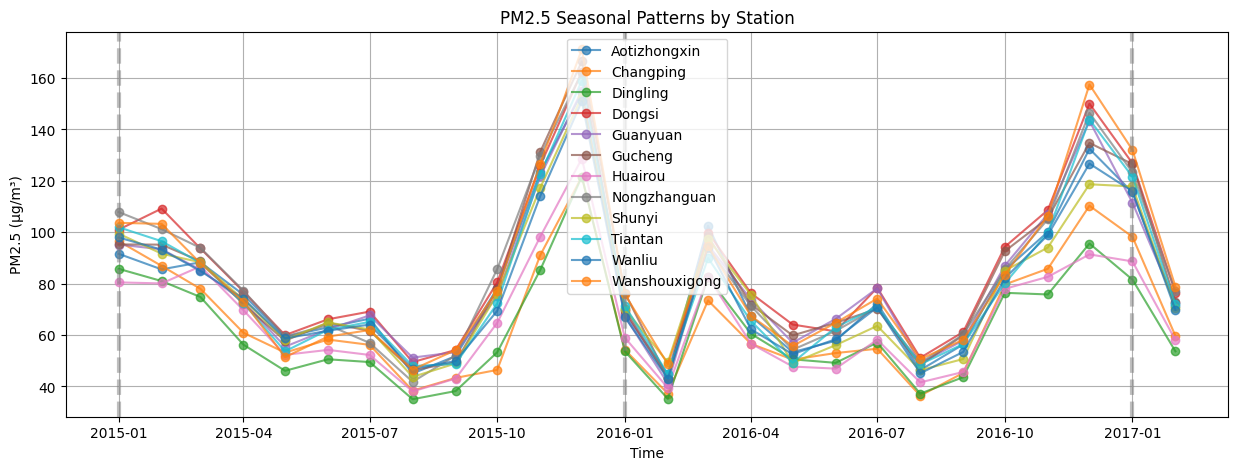

In [6]:
# Process monthly averages
monthly_data = process_monthly_data(raw_data, start=2015)
plot_seasonal_patterns(monthly_data)

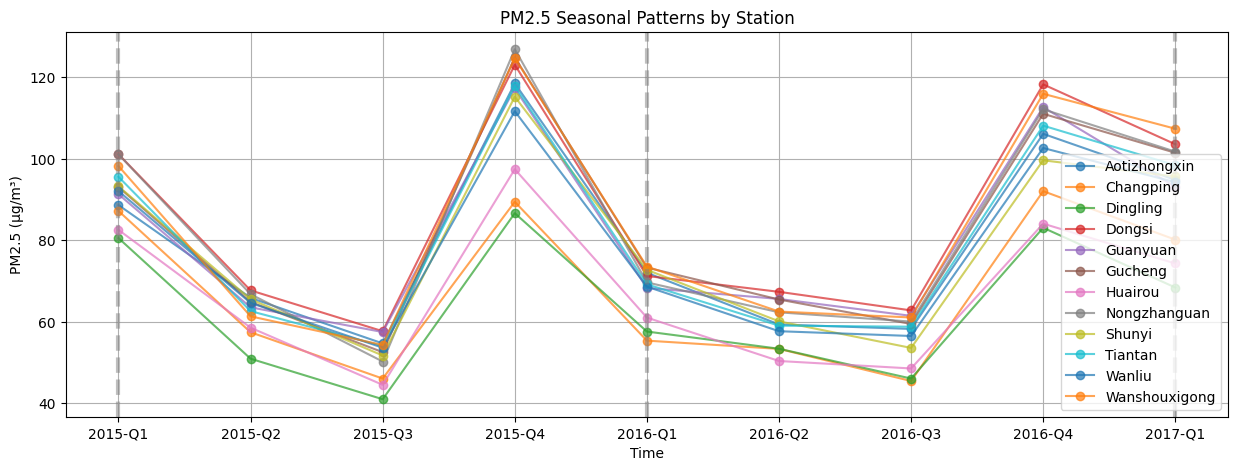

In [4]:
quarterly_data = process_quarterly_data(raw_data, start=2015, n_quarters=9)
plot_seasonal_patterns(quarterly_data, time_key="date", feature="PM2.5")

In [ ]:
# Train a MMFM model on the data
from mmfm.multi_marginal_fm import MultiMarginalFlowMatcher

MMFM = MultiMarginalFlowMatcher()


In [66]:
# Create population samples
population_data = create_population_samples(monthly_data)

# Visualize

# Print some statistics
print("\nDataset Statistics:")
print(f"Number of stations: {len(monthly_data['station'].unique())}")
print(f"Time period: {monthly_data['date'].min()} to {monthly_data['date'].max()}")
print(f"Total population samples: {len(population_data)}")


Dataset Statistics:
Number of stations: 12
Time period: 2013-03-01 00:00:00 to 2017-02-01 00:00:00
Total population samples: 28800



Points per month (single station):
Mean: 730.5
Min: 672
Max: 744

Points per month-station combination:
Mean: 730.5
Min: 672
Max: 744

Missing values per variable:
PM2.5     8739
PM10      6449
NO2      12116
CO       20701
O3       13277
SO2       9021
dtype: int64


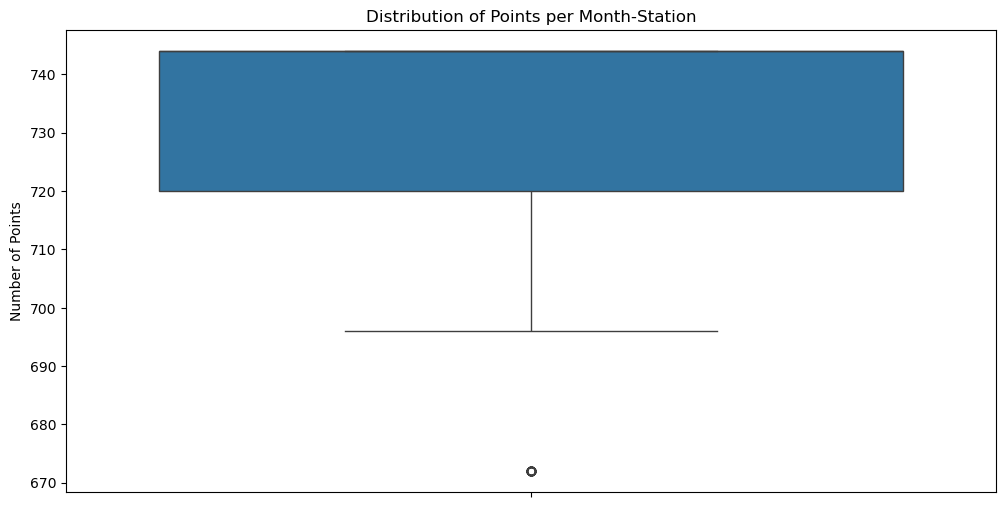

In [67]:
def analyze_data_distribution(data_dir="PRSA_Data_20130301-20170228"):
    """Analyze how many points we have per time-condition combination"""
    
    # Load first station to understand structure
    df = pd.read_csv(f"{data_dir}/PRSA_Data_Aotizhongxin_20130301-20170228.csv")
    
    # Convert to monthly data
    df['month_year'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    
    # Count points per month
    monthly_counts = df.groupby('month_year').size()
    
    print("\nPoints per month (single station):")
    print(f"Mean: {monthly_counts.mean():.1f}")
    print(f"Min: {monthly_counts.min()}")
    print(f"Max: {monthly_counts.max()}")
    
    # Load all stations
    stations = ['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 
               'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 
               'Shunyi', 'Tiantan', 'Wanliu', 'Wanshouxigong']
    
    all_data = []
    for station in stations:
        df = pd.read_csv(f"{data_dir}/PRSA_Data_{station}_20130301-20170228.csv")
        df['station'] = station
        df['month_year'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
        all_data.append(df)
    
    full_df = pd.concat(all_data)
    
    # Analyze points per month-station combination
    station_month_counts = full_df.groupby(['month_year', 'station']).size()
    
    print("\nPoints per month-station combination:")
    print(f"Mean: {station_month_counts.mean():.1f}")
    print(f"Min: {station_month_counts.min()}")
    print(f"Max: {station_month_counts.max()}")
    
    # Distribution of missing values
    missing_by_var = full_df[['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']].isna().sum()
    print("\nMissing values per variable:")
    print(missing_by_var)
    
    # Visualize distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=station_month_counts.reset_index(), y=0)
    plt.title('Distribution of Points per Month-Station')
    plt.ylabel('Number of Points')
    plt.show()
    
    return full_df, station_month_counts

monthly_data, counts = analyze_data_distribution()